<a href="https://colab.research.google.com/github/jaayg23/PLN/blob/main/2.%20Transformer/Mecanismo_de_atenci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Logo UNAL CHEC](https://www.funcionpublica.gov.co/documents/d/guest/logo-universidad-nacional)



# **Mecanismo de atención**
### Departamento de Ingeniería Eléctrica, Electrónica y Computación
#### Universidad Nacional de Colombia - Sede Manizales

#### Profesor: Diego A. Pérez

Objetivo. Entender la atención como un mecanismo de búsqueda (relevancia) seguido de una mezcla ponderada (síntesis), con ejemplos numéricos y de texto.

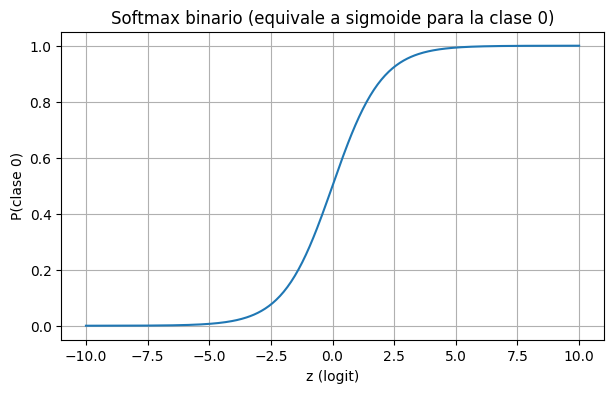

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def softmax(x):
    x = np.asarray(x, dtype=np.float64)
    x = x - np.max(x, axis=-1, keepdims=True)
    ex = np.exp(x)
    return ex / np.sum(ex, axis=-1, keepdims=True)

z = np.linspace(-10, 10, 400)
logits_bin = np.stack([z, np.zeros_like(z)], axis=-1)  # [z, 0]
p_class0 = softmax(logits_bin)[:, 0]

plt.figure(figsize=(7,4))
plt.plot(z, p_class0)
plt.title('Softmax binario (equivale a sigmoide para la clase 0)')
plt.xlabel('z (logit)')
plt.ylabel('P(clase 0)')
plt.grid(True)
plt.show()


¿Qué es la atención? con $Q, K, V$

La **atención** permite **enfocarse** en las partes más relevantes de la información para una **consulta**.
La versión estándar usa tres objetos:

* **Consulta(s)** $Q \in \mathbb{R}^{m \times d_k}$ — lo que “pregunta” el modelo (pueden ser $m$ consultas).
* **Claves** $K \in \mathbb{R}^{n \times d_k}$ — cómo “indexamos” la memoria (hay $n$ elementos).
* **Valores** $V \in \mathbb{R}^{n \times d_v}$ — la información que queremos combinar.

**Caso 1: una consulta** $\mathbf{q} \in \mathbb{R}^{d_k}$, claves $\mathbf{k}_i \in \mathbb{R}^{d_k}$, valores $\mathbf{v}_i \in \mathbb{R}^{d_v}$.

1. **Puntajes (similitud)**

$$
s_i \;=\; \mathbf{q}^\top \mathbf{k}_i
\quad\text{(o escalado: } s_i = \tfrac{\mathbf{q}^\top \mathbf{k}_i}{\sqrt{d_k}}\text{)}.
$$

2. **Pesos (softmax)**

$$
a_i \;=\; \frac{\exp(s_i)}{\sum_{j=1}^{n}\exp(s_j)},
\qquad \sum_i a_i = 1,\; a_i \ge 0.
$$

3. **Salida (mezcla ponderada)**

$$
\mathbf{o} \;=\; \sum_{i=1}^{n} a_i \,\mathbf{v}_i \;\in\; \mathbb{R}^{d_v}.
$$

**Caso 2: varias consultas** $Q \in \mathbb{R}^{m \times d_k}$. Forma matricial:

$$
S \;=\; \frac{QK^\top}{\sqrt{d_k}} \;\in\; \mathbb{R}^{m \times n},
\quad A \;=\; \text{softmax}_\text{fila}(S) \;\in\; \mathbb{R}^{m \times n},
\quad O \;=\; AV \;\in\; \mathbb{R}^{m \times d_v}.
$$

* $S_{ij}$ es la similitud entre la consulta $i$ y la clave $j$.
* Cada fila de $A$ es una distribución de probabilidad (suma 1).
* Cada fila de $O$ es la **respuesta** para una consulta distinta.

> Nota: El factor de **escalado** $\tfrac{1}{\sqrt{d_k}}$ estabiliza la magnitud de los puntajes cuando $d_k$ es grande.


In [2]:


import numpy as np

def softmax(x, axis=-1):
    x = np.asarray(x, dtype=np.float64)
    x = x - np.max(x, axis=axis, keepdims=True)  # estabilidad numérica
    ex = np.exp(x)
    return ex / np.sum(ex, axis=axis, keepdims=True)

def attention_single_query(q, K, V, scale=True):
    """
    q:  (d_k,)
    K:  (n, d_k)
    V:  (n, d_v)
    return: o (d_v,), a (n,), s (n,)
    """
    s = K @ q  # (n,)
    if scale:
        d_k = K.shape[1]
        s = s / np.sqrt(d_k)
    a = softmax(s, axis=0)     # (n,)
    o = a @ V                  # (d_v,)
    return o, a, s

def attention_multi(Q, K, V, scale=True):
    """
    Q: (m, d_k)
    K: (n, d_k)
    V: (n, d_v)
    return: O (m, d_v), A (m, n), S (m, n)
    """
    S = Q @ K.T  # (m, n)
    if scale:
        d_k = K.shape[1]
        S = S / np.sqrt(d_k)
    A = softmax(S, axis=1)     # softmax por filas
    O = A @ V
    return O, A, S


In [3]:
q = np.array([1.0, 0.0])                 # consulta alineada al eje x
K = np.array([[1.0, 0.0],                # k1 ~ muy parecido a q
              [0.0, 1.0],                # k2 ~ ortogonal
              [0.8, 0.2]])               # k3 ~ parecido a q
V = np.array([[1.0, 0.0],                # v1
              [0.0, 1.0],                # v2
              [0.5, 0.5]])               # v3 (info mixta)

o, a, s = attention_single_query(q, K, V, scale=True)

print("Similitudes s (escaladas):", np.round(s, 3))
print("Pesos a (softmax)        :", np.round(a, 3))
print("Suma de pesos            :", np.round(a.sum(), 3))
print("Salida o                 :", np.round(o, 3))


Similitudes s (escaladas): [0.707 0.    0.566]
Pesos a (softmax)        : [0.424 0.209 0.368]
Suma de pesos            : 1.0
Salida o                 : [0.607 0.393]


**Qué debes observar:**

* El mayor peso debería concentrarse en la clave más parecida a $q$ (aquí, la primera).
* La salida $\mathbf{o}$ es una **mezcla** de las filas de $V$ con esos pesos.


In [4]:

# Dos consultas en d_k = 3
Q = np.array([[ 1.0,  0.0,  0.0],    # consulta 1 (tipo 'eje x')
              [ 0.0,  0.9,  0.1]])   # consulta 2 (cercana al eje y)

# Tres claves/valores (n = 3), d_k = 3, d_v = 2
K = np.array([[1.0, 0.0, 0.0],
              [0.1, 0.9, 0.0],
              [0.2, 0.1, 0.9]])
V = np.array([[1.0, 0.0],    # v1
              [0.2, 0.8],    # v2
              [0.6, 0.4]])   # v3

O, A, S = attention_multi(Q, K, V, scale=True)

np.set_printoptions(precision=3, suppress=True)
print("S (puntajes escalados):\n", S)
print("\nA (pesos por fila; suman 1):\n", A, "\nFilas suman:", A.sum(axis=1))
print("\nO (salidas por consulta):\n", O)

S (puntajes escalados):
 [[0.577 0.058 0.115]
 [0.    0.468 0.104]]

A (pesos por fila; suman 1):
 [[0.449 0.267 0.283]
 [0.27  0.431 0.299]] 
Filas suman: [1. 1.]

O (salidas por consulta):
 [[0.673 0.327]
 [0.536 0.464]]



**Qué debes observar:**

* **Fila 1** de $A$: más peso en la clave similar a $[1,0,0]$ $\Rightarrow$ favorece $V_1$.
* **Fila 2** de $A$: más peso en la clave similar a $[0,1,0]$ $\Rightarrow$ favorece $V_2$.
* Cada **fila de $O$** es la salida para cada consulta.




In [5]:

# Oración: "el gato duerme tranquilo"
vocab = ["el", "gato", "duerme", "tranquilo"]

# Embeddings simples (d_k = 3) para ilustrar conceptos (animal/acción/calma)
K = np.array([
    [0.1, 0.0, 0.1],   # el
    [0.9, 0.1, 0.0],   # gato  ~ 'animal'
    [0.2, 0.8, 0.1],   # duerme ~ 'acción'
    [0.1, 0.2, 0.7],   # tranquilo ~ 'calma'
], dtype=float)

# Tomamos V = K (podrían ser distintas en general)
V = np.array([[1.0, 0.0],    # v1
              [0.2, 0.8],    # v2
              [0.6, 0.4],
              [0.0, 1]])   # v3

# Consulta 'animal'
q_animal = np.array([1.0, 0.0, 0.0])

o, a, s = attention_single_query(q_animal, K, V, scale=True)

print("Puntajes (s):", dict(zip(vocab, np.round(s,3))))
print("Pesos (a)   :", dict(zip(vocab, np.round(a,3))))
print("Salida (o)  :", np.round(o, 3))



Puntajes (s): {'el': np.float64(0.058), 'gato': np.float64(0.52), 'duerme': np.float64(0.115), 'tranquilo': np.float64(0.058)}
Pesos (a)   : {'el': np.float64(0.215), 'gato': np.float64(0.342), 'duerme': np.float64(0.228), 'tranquilo': np.float64(0.215)}
Salida (o)  : [0.42 0.58]


**Qué debes observar:**

* El mayor peso debería recaer sobre **“gato”** cuando la consulta es “animal”.
* La salida es una combinación de los “valores” ponderados por esos pesos.



Q shape: (4, 4) K: (10, 4) V: (10, 2)
scores :
 [[ 0.173 -0.293 -0.236 -0.378  0.042  0.297  0.293  0.607  0.077 -0.435]
 [ 0.851  0.014 -1.146 -0.595  0.449  1.37   1.858  1.751 -0.584 -0.533]
 [ 0.285 -0.605 -0.165  0.332 -0.346  0.099 -0.918 -0.308 -1.602 -0.004]
 [ 0.029  0.286 -0.26   1.214 -0.138 -0.261  0.174 -1.899 -2.019  0.591]]
weights:
 [[0.111 0.07  0.074 0.064 0.097 0.126 0.125 0.171 0.101 0.06 ]
 [0.102 0.044 0.014 0.024 0.068 0.171 0.278 0.25  0.024 0.025]
 [0.161 0.066 0.103 0.169 0.086 0.134 0.048 0.089 0.024 0.121]
 [0.09  0.117 0.068 0.295 0.076 0.067 0.104 0.013 0.012 0.158]]
row sums (≈1): [1. 1. 1. 1.]
O:
 [[ 0.575 -0.247]
 [ 0.58  -0.269]
 [ 0.759 -0.201]
 [ 0.883 -0.607]]


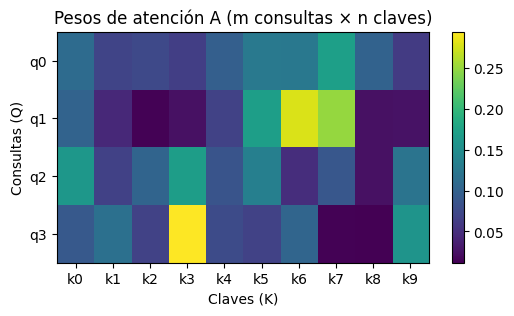

In [6]:
import numpy as np
import matplotlib.pyplot as plt



# ===== Parámetros (ajustan tu ejemplo original) =====
rng = np.random.default_rng(0)
d_k = 4   # dimensión de consulta/clave (antes decías "R^4", aquí es 10)
d_v = 2    # dimensión de valor (elige la que prefieras)
n   = 10    # número de (clave, valor)
m=4
# ===== Q, K, V (una consulta) =====
Q = rng.normal(size=(m,d_k))      # (d_k,)
K = rng.normal(size=(n, d_k))    # (n, d_k)  ← reemplaza a tu M
V = rng.normal(size=(n, d_v))    # (n, d_v)
# Si quieres replicar tu versión "o = weights @ M", usa: V = K.copy()
o,weights,scores=attention_multi(Q, K, V, scale=True)
# ===== Attention (scaled dot-product) =====
       # (d_v,)

# ===== Resultados =====
# ===== Resultados =====
np.set_printoptions(precision=3, suppress=True)
print("Q shape:", Q.shape, "K:", K.shape, "V:", V.shape)
print("scores :\n", scores.round(3))
print("weights:\n", weights.round(3))
print("row sums (≈1):", weights.sum(axis=1).round(3))  # suma por FILAS (m,)
print("O:\n", o.round(3))

# ===== Visualización de pesos (heatmap m×n) =====
plt.figure(figsize=(6, 3))
plt.imshow(weights, aspect='auto')   # <- usa la matriz 2D directamente
plt.colorbar()
plt.yticks(range(m), [f"q{i}" for i in range(m)])
plt.xticks(range(n), [f"k{j}" for j in range(n)])
plt.title("Pesos de atención A (m consultas × n claves)")
plt.xlabel("Claves (K)")
plt.ylabel("Consultas (Q)")
plt.show()


Piensa en un archivo con cajones:

* La etiqueta del cajón (K) te ayuda a saber qué cajón abrir según tu consulta (Q).

* El contenido del cajón (V) es lo que sacas para trabajar.
La atención calcula cuánto abrir cada cajón (pesos) y luego mezcla lo que sacaste de todos (combinación convexa de
V).

*Soft* vs *Hard* attention

* **Soft attention:** reparte pesos **continuos** con *softmax* (derivable).
* **Hard attention:** elige **un** elemento (p.ej., con $\arg\max$), no es directamente derivable.

Si $s_i$ son los puntajes:

* *Hard*: $i^* = \arg\max_i s_i \;\; \Rightarrow \;\; \mathbf{o} = \mathbf{m}_{i^*}.$
* *Soft*: $a_i = \text{softmax}(s_i) \;\; \Rightarrow \;\; \mathbf{o} = \sum_i a_i \mathbf{m}_i.$



=== HARD vs SOFT ===
hard_idx (por consulta): [7 6 3 3]

A_soft (primeras filas):
 [[0.111 0.07  0.074 0.064 0.097 0.126 0.125 0.171 0.101 0.06 ]
 [0.102 0.044 0.014 0.024 0.068 0.171 0.278 0.25  0.024 0.025]
 [0.161 0.066 0.103 0.169 0.086 0.134 0.048 0.089 0.024 0.121]]

A_hard (one-hot):
 [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]

O_soft:
 [[ 0.575 -0.247]
 [ 0.58  -0.269]
 [ 0.759 -0.201]
 [ 0.883 -0.607]]

O_hard:
 [[ 0.052  0.684]
 [ 0.633 -2.204]
 [ 1.739 -0.496]
 [ 1.739 -0.496]]

||O_soft - O_hard||_2 por consulta: [1.068 1.935 1.024 0.864]

row sums A_soft: [1. 1. 1. 1.]
row sums A_hard: [1. 1. 1. 1.]


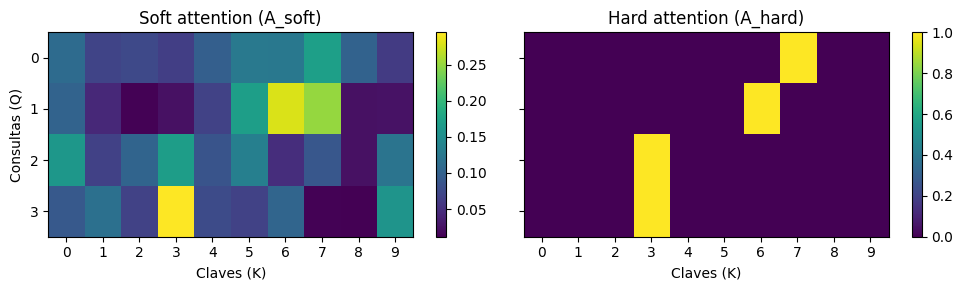

In [7]:
# =========================
# HARD vs SOFT (multi-consulta)
# =========================

# Soft ya lo tienes:
A_soft = weights              # (m, n)
O_soft = o                    # (m, d_v)
S      = scores               # (m, n)

# Hard: tomar el argmax por cada consulta (fila)
hard_idx = np.argmax(S, axis=1)     # (m,)
A_hard   = np.eye(n)[hard_idx]      # (m, n) one-hot por fila
O_hard   = A_hard @ V               # (m, d_v)

# Comparativa numérica
np.set_printoptions(precision=3, suppress=True)
print("\n=== HARD vs SOFT ===")
print("hard_idx (por consulta):", hard_idx)
print("\nA_soft (primeras filas):\n", A_soft[:min(3,m)])
print("\nA_hard (one-hot):\n", A_hard)
print("\nO_soft:\n", O_soft)
print("\nO_hard:\n", O_hard)
print("\n||O_soft - O_hard||_2 por consulta:",
      np.linalg.norm(O_soft - O_hard, axis=1).round(4))

# Sumas por fila (A_soft debe ~1, A_hard exactamente 1)
print("\nrow sums A_soft:", A_soft.sum(axis=1).round(3))
print("row sums A_hard:", A_hard.sum(axis=1).round(3))

# Visualización: heatmap soft vs hard
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

im0 = axes[0].imshow(A_soft, aspect='auto')
axes[0].set_title("Soft attention (A_soft)")
axes[0].set_xlabel("Claves (K)")
axes[0].set_ylabel("Consultas (Q)")
axes[0].set_xticks(range(n))
axes[0].set_yticks(range(m))
fig.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(A_hard, aspect='auto')
axes[1].set_title("Hard attention (A_hard)")
axes[1].set_xlabel("Claves (K)")
axes[1].set_xticks(range(n))
axes[1].set_yticks(range(m))
fig.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()


Temperatura en *softmax*

La **temperatura** $\tau > 0$ controla la **concentración** de los pesos:

$$
a_i(\tau) \;=\; \frac{\exp\!\left(s_i/\tau\right)}{\sum_j \exp\!\left(s_j/\tau\right)}.
$$

* $\tau \to 0$: distribución muy “afilada” (casi *hard*).
* $\tau$ grande: distribución más **uniforme** (dispersa).

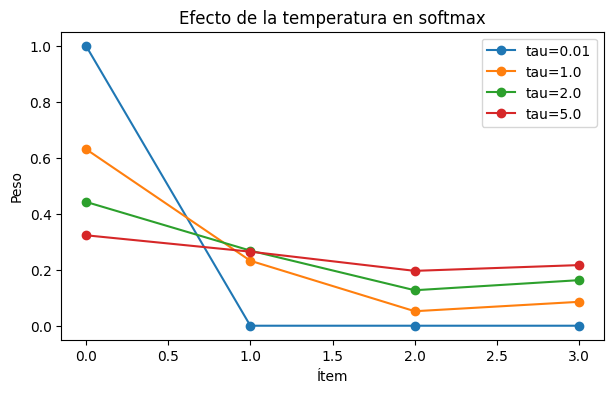

In [8]:
def softmax_temp(scores, tau=1.0):
    s = scores / tau
    s = s - np.max(s)
    ex = np.exp(s)
    return ex / np.sum(ex)

scores = np.array([2.0, 1.0, -0.5, 0.0])
taus = [0.01, 1.0, 2.0, 5.0]

plt.figure(figsize=(7,4))
for tau in taus:
    w = softmax_temp(scores, tau)
    plt.plot(range(len(scores)), w, marker='o', label=f'tau={tau}')
plt.title("Efecto de la temperatura en softmax")
plt.xlabel("Ítem")
plt.ylabel("Peso")
plt.legend()
plt.show()

#Self-Attention.

Sea un conjunto de **características crudas**

$$
X' \in \mathbb{R}^{n\times P},
$$

donde $n$ es la longitud de la secuencia (tokens/patches/pasos temporales) y $P$ es el número de **features** por elemento.
Antes de aplicar atención, las llevamos al espacio del modelo mediante una **función de embedding/encoder**

$$
f:\;\mathbb{R}^{n\times P}\to \mathbb{R}^{n\times d_{\text{model}}},\qquad X \;=\; f(X').
$$

Casos típicos de $f$:

* **Lineal (embedding denso):** $f(X') = X'W_E + \mathbf{1}b^\top$, con $W_E\in\mathbb{R}^{P\times d_{\text{model}}}$, $b\in\mathbb{R}^{d_{\text{model}}}$.
* **No lineal (MLP/CNN):** $f(X')=\phi(X'W_1)W_2$ u otras variantes (audio/imágenes/tabular).
* **NLP (one-hot $\to$ embedding):** $X'[i]$ selecciona la fila $E[\text{token}_i]$ de una matriz de embeddings $E\in\mathbb{R}^{|\mathcal{V}|\times d_{\text{model}}}$.

$$
Q = XW_Q,\quad K = XW_K,\quad V = XW_V,
$$

donde $W_Q \in \mathbb{R}^{d_\text{model}\times d_k}$, $W_K \in \mathbb{R}^{d_\text{model}\times d_k}$, $W_V \in \mathbb{R}^{d_\text{model}\times d_v}$.

La **atención** se calcula así:

$$
S \;=\; \frac{QK^\top}{\sqrt{d_k}} \;\in\; \mathbb{R}^{n \times n},\qquad
A \;=\; \mathrm{softmax}_\text{fila}(S) \;\in\; \mathbb{R}^{n \times n},\qquad
O \;=\; AV \;\in\; \mathbb{R}^{n \times d_v}.
$$

* $S_{ij}$ mide similitud entre la consulta del token $i$ y la clave del token $j$.
* Cada fila de $A$ es una distribución (suma $1$).
* Cada fila de $O$ es la **salida** para el token $i$, mezcla ponderada de los valores.

> El factor $\tfrac{1}{\sqrt{d_k}}$ estabiliza la escala de $S$ cuando $d_k$ es grande.


In [9]:
import numpy as np

np.set_printoptions(precision=3, suppress=True)

def softmax(x, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)  # estable
    ex = np.exp(x)
    return ex / np.sum(ex, axis=axis, keepdims=True)

# Datos pequeños reproducibles
rng = np.random.default_rng(0)
n, d_model, d_k, d_v = 4, 6, 3, 2
X = rng.normal(size=(n, d_model))

# Proyecciones aprendibles (simuladas)
W_Q = rng.normal(size=(d_model, d_k))
W_K = rng.normal(size=(d_model, d_k))
W_V = rng.normal(size=(d_model, d_v))

Q = X @ W_Q    # (n, d_k)
K = X @ W_K    # (n, d_k)
V = X @ W_V    # (n, d_v)

S = (Q @ K.T) / np.sqrt(d_k)   # (n, n)
A = softmax(S, axis=1)         # (n, n) filas suman ~1
O = A @ V                      # (n, d_v)

print("Shapes -> X:", X.shape, "Q:", Q.shape, "K:", K.shape, "V:", V.shape)
print("S (scores):\n", S)
print("A (weights), row sums:", A.sum(axis=1))
print("O (output):\n", O)

Shapes -> X: (4, 6) Q: (4, 3) K: (4, 3) V: (4, 2)
S (scores):
 [[ 0.662  0.47  -0.264 -0.5  ]
 [ 1.332  0.176  0.783 -2.675]
 [-1.587 -1.049  0.856  1.651]
 [ 1.429  1.71  -2.337 -0.036]]
A (weights), row sums: [1. 1. 1. 1.]
O (output):
 [[-0.383  0.652]
 [-0.735  1.329]
 [ 1.703  2.495]
 [-0.596 -0.301]]


*Masking*: **padding** y **causal**

En atención usamos una **máscara** $M \in \mathbb{R}^{n\times n}$ para **anular** contribuciones no permitidas **antes** del *softmax*:

* $M_{ij} = 0$ si se **permite** que la consulta $i$ atienda a la clave $j$ $(i\to j)$.
* $M_{ij} = -\infty$ si se **prohíbe** (eso forzará peso $0$ tras el *softmax*).

Se aplica así:

$$
S_{\text{masc}} \;=\; S + M,
\qquad
A \;=\; \mathrm{softmax}_\text{fila}(S_{\text{masc}}).
$$

**Tipos comunes**

* **Padding mask**: bloquea posiciones “vacías” (tokens de relleno).
  *Ejemplo práctico:* oración “el gato duerme \<pad> \<pad>” → prohíbe atender a las columnas 3 y 4.
* **Causal mask**: impide “mirar al futuro” en decodificadores autoregresivos.
  Es una máscara triangular inferior: **solo** permite $j \le i$.

> En la práctica, en lugar de $-\infty$ se usa un número muy negativo (p. ej. $-1\mathrm{e}{9}$) para evitar problemas de *dtype*.




Row sums (sin máscara):       [1. 1. 1. 1. 1.]
Row sums (padding):           [1. 1. 1. 1. 1.]
Row sums (causal):            [1. 1. 1. 1. 1.]
Row sums (padding + causal):  [1. 1. 1. 1. 1.]


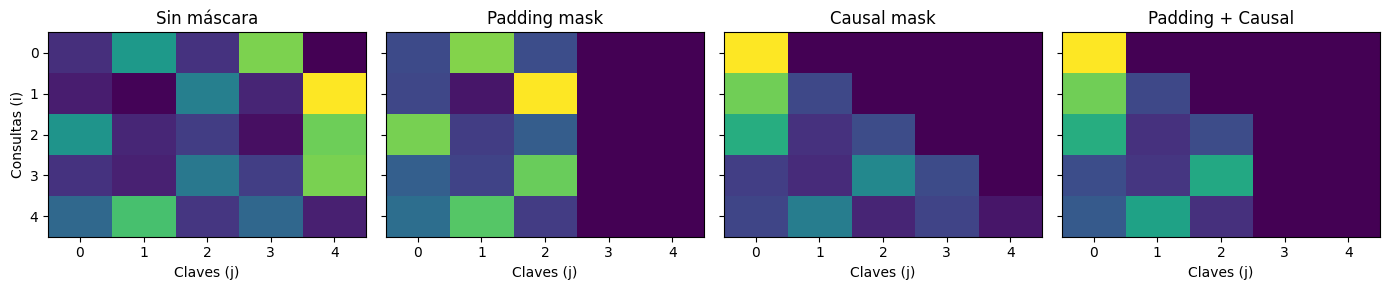


Distribuciones de atención para la consulta i=3:
Sin máscara    : [0.096 0.064 0.245 0.119 0.476]
Padding        : [0.238 0.157 0.605 0.    0.   ]  <- sin peso en columnas <pad>
Causal         : [0.184 0.122 0.467 0.227 0.   ]  <- sin peso para j>i (futuro)
Padding+Causal : [0.238 0.157 0.605 0.    0.   ]  <- aplica ambas restricciones


In [10]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)

def softmax(x, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)  # estabilidad
    ex = np.exp(x)
    return ex / np.sum(ex, axis=axis, keepdims=True)

def causal_mask(n):
    M = np.triu(np.ones((n, n)), k=1)   # 1 por encima de la diagonal
    M[M == 1] = -np.inf                 # prohibir futuro
    M[M == 0] = 0.0
    return M

def apply_mask_and_softmax(S, M=None):
    if M is not None:
        S = S + M
    return softmax(S, axis=1)

# ===== Ejemplo reproducible =====
rng = np.random.default_rng(3)
n, d_k = 5, 4

# Simulamos Q,K para construir S = QK^T / sqrt(d_k)
Q = rng.normal(size=(n, d_k))
K = rng.normal(size=(n, d_k))
S = (Q @ K.T) / np.sqrt(d_k)  # (n, n) puntajes sin máscara

# ===== Máscaras =====
# 1) Padding: supongamos que las últimas 2 posiciones son <pad>
M_pad = np.zeros((n, n))
M_pad[:, -2:] = -np.inf   # bloquea columnas 3 y 4 (indexadas 3,4)

# 2) Causal: no mirar al futuro (j > i)
M_causal = causal_mask(n)

# 3) Combinada: padding + causal
#    Suma de máscaras (donde cualquiera prohíbe, se prohíbe).
M_both = M_pad + M_causal

# ===== Atenciones =====
A_free   = apply_mask_and_softmax(S, None)     # sin máscara
A_pad    = apply_mask_and_softmax(S, M_pad)    # con padding
A_causal = apply_mask_and_softmax(S, M_causal) # causal
A_both   = apply_mask_and_softmax(S, M_both)   # padding + causal

print("Row sums (sin máscara):      ", A_free.sum(axis=1))
print("Row sums (padding):          ", A_pad.sum(axis=1))
print("Row sums (causal):           ", A_causal.sum(axis=1))
print("Row sums (padding + causal): ", A_both.sum(axis=1))

# ===== Visualización rápida (heatmaps) =====
fig, axes = plt.subplots(1, 4, figsize=(14, 3), sharey=True)

ims = []
ims.append(axes[0].imshow(A_free,   aspect='auto'));   axes[0].set_title("Sin máscara")
ims.append(axes[1].imshow(A_pad,    aspect='auto'));   axes[1].set_title("Padding mask")
ims.append(axes[2].imshow(A_causal, aspect='auto'));   axes[2].set_title("Causal mask")
ims.append(axes[3].imshow(A_both,   aspect='auto'));   axes[3].set_title("Padding + Causal")

for ax in axes:
    ax.set_xlabel("Claves (j)")
axes[0].set_ylabel("Consultas (i)")
#fig.colorbar(ims[0], ax=axes, fraction=0.025, pad=0.04)
plt.tight_layout()
plt.show()

# ===== Ejemplo interpretativo por fila =====
i = 3  # consulta i (p. ej., token en posición 3)
print(f"\nDistribuciones de atención para la consulta i={i}:")
print("Sin máscara    :", np.round(A_free[i], 3))
print("Padding        :", np.round(A_pad[i], 3),   " <- sin peso en columnas <pad>")
print("Causal         :", np.round(A_causal[i], 3)," <- sin peso para j>i (futuro)")
print("Padding+Causal :", np.round(A_both[i], 3),  " <- aplica ambas restricciones")


**¿Dónde se usan?**

* **Padding mask**

  * **Encoder (Transformers bidireccionales, p. ej. BERT):** evita que se atienda a tokens de relleno en secuencias de longitud variable.
  * **Cross-attention (decodificador ↔ encoder):** el decodificador no debe “copiar” información de posiciones \<pad> del encoder.
  * **Tareas típicas:** clasificación de oraciones, NER, QA extractivo (cuando el input se rellena), traducción (lado encoder), ASR no auto-regresivo, visión (patches fuera de imagen útil).
  * **Beneficios:** estabilidad (evita “fugas” de atención a basura), mejor uso del softmax (probabilidad se reparte solo en posiciones válidas), métricas más consistentes.
  * **Deficiencias:** requiere construir/propagar máscaras correctas; si se calcula mal, se “censura” información válida o se permite ruido.

* **Causal mask (autoregresiva)**

  * **Decoder self-attention (GPT/LM autoregresivos):** prohíbe mirar **al futuro**; cada token solo atiende a sí mismo y al pasado.
  * **Tareas típicas:** generación de texto paso a paso, traducción autoregresiva, ASR streaming, modelado de series temporales y audio en tiempo real.
  * **Beneficios:** impone la **dirección temporal** correcta; permite despliegue **en línea/streaming**; evita “trampas” (información futura).
  * **Deficiencias:** renuncia a **contexto futuro** que sería útil si estuviera disponible (peor calidad que un modelo no causal en escenarios offline).

* **Máscara combinada (padding + causal)**

  * **Decoder autoregresivo con entradas con padding:** simultáneamente impide futuro y posiciones \<pad> (propio cuando hay lotes con longitudes distintas).
  * **Beneficios:** comportamiento correcto **y** robusto a longitudes variables; la atención siempre se reparte entre posiciones **válidas** y **anteriores**.
  * **Deficiencias:** ligera **complejidad** extra en construcción/gestión de máscaras; errores de indexado son más fáciles si no se testea.


Dimensión de lote (batch) y forma general

Con lotes, las formas son:

$$
Q \in \mathbb{R}^{B \times n \times d_k},\quad
K \in \mathbb{R}^{B \times n \times d_k},\quad
V \in \mathbb{R}^{B \times n \times d_v}.
$$

Se calcula por lote:

$$
S[b] \;=\; \frac{Q[b]\,K[b]^\top}{\sqrt{d_k}},\quad
A[b] \;=\; \mathrm{softmax}_\text{fila}(S[b]),\quad
O[b] \;=\; A[b]\,V[b].
$$

In [11]:
def sdpa_batched(Q, K, V, mask=None):
    """
    Q,K,V: (B, n, d_k/d_v)
    mask:  (n, n) o (B, n, n) con 0 y -inf
    """
    B, n, d_k = Q.shape
    # S = Q @ K^T por lote
    S = np.matmul(Q, np.swapaxes(K, -1, -2)) / np.sqrt(d_k)  # (B, n, n)
    if mask is not None:
        if mask.ndim == 2:
            S = S + mask[None, :, :]
        else:
            S = S + mask
    # softmax por filas (eje=-1)
    S_shift = S - np.max(S, axis=-1, keepdims=True)
    A = np.exp(S_shift)
    A = A / np.sum(A, axis=-1, keepdims=True)
    O = np.matmul(A, V)  # (B, n, d_v)
    return O, A, S

# Prueba con B=2, n=3
B, n, d_k, d_v = 2, 3, 4, 5
Qb = rng.normal(size=(B, n, d_k))
Kb = rng.normal(size=(B, n, d_k))
Vb = rng.normal(size=(B, n, d_v))
O_b, A_b, S_b = sdpa_batched(Qb, Kb, Vb, mask=causal_mask(n))

print("Shapes batched -> O:", O_b.shape, "A:", A_b.shape, "S:", S_b.shape)
print("Row sums batch 0:", A_b[0].sum(axis=1))

Shapes batched -> O: (2, 3, 5) A: (2, 3, 3) S: (2, 3, 3)
Row sums batch 0: [1. 1. 1.]


**Dot-Product vs Additive (Bahdanau)** con $Q=XW_Q,\;K=XW_K,\;V=XW_V$

Sea $X\in\mathbb{R}^{n\times d_{\text{model}}}$ y las proyecciones

$$
Q=XW_Q,\quad K=XW_K,\quad V=XW_V,
$$

con $W_Q,W_K\in\mathbb{R}^{d_{\text{model}}\times d_k}$ y $W_V\in\mathbb{R}^{d_{\text{model}}\times d_v}$.

| Aspecto         | **Dot-Product (escalado)**                                                                   | **Additive (Bahdanau)**                                                                                                                                                                  |
| --------------- | -------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Puntajes**    | $\displaystyle S \;=\; \frac{QK^\top}{\sqrt{d_k}}\;\in\;\mathbb{R}^{n\times n}$              | $\displaystyle S_{\text{add}}[i,j] \;=\; \mathbf{w}^\top \tanh\!\Big((QW_q^\top)_{i,:} + (KW_k^\top)_{j,:}\Big)$ con $W_q,W_k\in\mathbb{R}^{h\times d_k},\;\mathbf{w}\in\mathbb{R}^{h}$. |
| **Pesos**       | $A=\mathrm{softmax}_\text{fila}(S)$                                                          | $A_{\text{add}}=\mathrm{softmax}_\text{fila}(S_{\text{add}})$                                                                                                                            |
| **Salida**      | $O = A\,V \in \mathbb{R}^{n\times d_v}$                                                      | $O_{\text{add}} = A_{\text{add}}\,V \in \mathbb{R}^{n\times d_v}$                                                                                                                        |
| **Uso típico**  | Transformers modernos (encoder, decoder, cross-attn)                                         | Seq2seq RNN clásico; escenarios con $d_k$ pequeño o donde una no linealidad ayuda a alinear                                                                                              |
| **Ventajas**    | Muy **eficiente** (GEMMs, GPU/TPU); simple; escala bien; el factor $1/\sqrt{d_k}$ estabiliza | **Más expresivo** localmente (alineamientos no lineales) con $h$ pequeño                                                                                                                 |
| **Desventajas** | Sin el escalado, para $d_k$ grande el *softmax* se “afila” demasiado                         | **Más costoso** (MLP por par $(i,j)$); más parámetros; menos throughput                                                                                                                  |

**Notas de forma:**

* En dot-product, toda la operación se expresa en álgebra matricial estándar.
* En aditiva, suele implementarse con *broadcasting*: $Q' = QW_q^\top\in\mathbb{R}^{n\times h}$, $K' = KW_k^\top\in\mathbb{R}^{n\times h}$ y
  $\displaystyle S_{\text{add}}[i,j] = \mathbf{w}^\top \tanh\!\big(Q'_{i,:}+K'_{j,:}\big)$.
* En ambos casos, **la lógica posterior es la misma**: *softmax por filas* y mezcla $V$.


s_dot: [-0.753 -0.319 -0.445  0.766  0.017  0.557]
s_add: [-3.175 -3.177 -2.989 -0.497 -1.473 -0.714]

a_dot: [0.07  0.108 0.095 0.319 0.151 0.259]  sum: 1.0
a_add: [0.029 0.029 0.034 0.416 0.157 0.335]  sum: 1.0

o_dot: [ 0.364  0.001 -0.817]
o_add: [ 0.433  0.17  -0.825]

||o_dot - o_add||_2: 0.1826


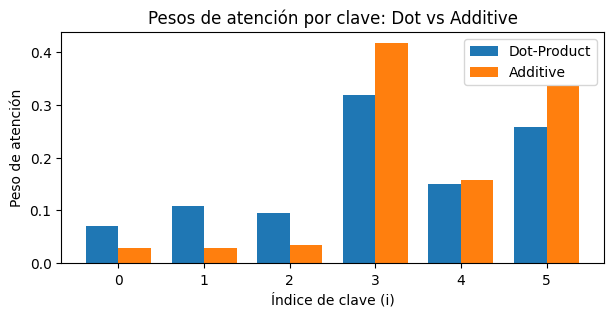

In [12]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)

def softmax(x, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)
    ex = np.exp(x)
    return ex / np.sum(ex, axis=axis, keepdims=True)

# ----- Datos pequeños reproducibles -----
rng = np.random.default_rng(7)
d_k, d_v, n = 4, 3, 6    # dimensión de claves/consulta, valores, nº de claves
q = rng.normal(size=(d_k,))      # una consulta
K = rng.normal(size=(n, d_k))    # n claves
V = rng.normal(size=(n, d_v))    # n valores

# ----- Dot-Product (escalado) -----
s_dot = (K @ q) / np.sqrt(d_k)   # (n,)
a_dot = softmax(s_dot)           # (n,)
o_dot = a_dot @ V                # (d_v,)

# ----- Additive (Bahdanau) -----
h = 8  # ancho del MLP de alineación
Wq = rng.normal(size=(h, d_k))
Wk = rng.normal(size=(h, d_k))
w  = rng.normal(size=(h,))

# s_add[i] = w^T tanh( Wq q + Wk k_i )
t = np.tanh(Wq @ q[:, None] + (Wk @ K.T))  # (h, n)
s_add = (w @ t)                            # (n,)
a_add = softmax(s_add)
o_add = a_add @ V

print("s_dot:", s_dot.round(3))
print("s_add:", s_add.round(3))
print("\na_dot:", a_dot.round(3), " sum:", a_dot.sum().round(3))
print("a_add:", a_add.round(3), " sum:", a_add.sum().round(3))
print("\no_dot:", o_dot.round(3))
print("o_add:", o_add.round(3))
print("\n||o_dot - o_add||_2:", np.linalg.norm(o_dot - o_add).round(4))

# ----- Visual: pesos lado a lado -----
x = np.arange(n)
width = 0.38
plt.figure(figsize=(7,3))
plt.bar(x - width/2, a_dot, width, label="Dot-Product")
plt.bar(x + width/2, a_add, width, label="Additive")
plt.title("Pesos de atención por clave: Dot vs Additive")
plt.xlabel("Índice de clave (i)")
plt.ylabel("Peso de atención")
plt.xticks(x)
plt.legend()
plt.show()


Resumen y siguientes pasos

* **Operación matemática**: $O=\mathrm{softmax}\!\left(QK^\top/\sqrt{d_k}\right)V$ con proyecciones $W_Q, W_K, W_V$.
* **Máscaras**: controlan qué posiciones pueden atenderse (padding/causal).
* **Estabilidad**: resta del máximo y escalado por $\sqrt{d_k}$; **temperatura** para afilar/aplanar pesos.
* **Batch**: misma operación por lote.
* **Variantes**: dot-product vs aditiva.


In [13]:
import numpy as np
import pandas as pd

# 1) Carga de datos
url = "https://raw.githubusercontent.com/juacardonahe/Curso_NLP/refs/heads/main/data/SMSSpamCollection/SMSSpamCollection"
df = pd.read_csv(url, sep='\t', header=None, names=['label', 'message'])
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# 2) Longitud (percentil 95) y split
df['message_length'] = df['message'].apply(lambda x: len(str(x).split()))
max_length = int(df['message_length'].quantile(0.95))
print("Max sequence length (95th):", max_length)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df['message'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# 3) Tokenizador y secuencias
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(oov_token="<unk>")
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
print("Vocab size:", vocab_size)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='pre', truncating='pre')
X_test_pad  = pad_sequences(X_test_seq,  maxlen=max_length, padding='pre', truncating='pre')

# 4) Class weights
from sklearn.utils.class_weight import compute_class_weight
cw = compute_class_weight(class_weight='balanced', classes=np.array([0,1]), y=y_train.values)
class_weights = {0: float(cw[0]), 1: float(cw[1])}
class_weights


Max sequence length (95th): 33
Vocab size: 7935


{0: 0.577481212749417, 1: 3.7265886287625416}

In [14]:


import tensorflow as tf
from tensorflow.keras import layers, Model

tf.keras.backend.clear_session()

# Dimensiones
embed_dim = 128
d_model   = 128
d_k       = 64
d_v       = 64

inputs = layers.Input(shape=(max_length,), dtype="int32", name="tokens")

# --- Máscara de padding (1=token, 0=pad) envuelta en Lambda ---
mask      = layers.Lambda(lambda x: tf.cast(tf.not_equal(x, 0), tf.float32), name="mask_bool")(inputs)     # (B,T)
mask_exp  = layers.Lambda(lambda m: tf.expand_dims(m, axis=1),                       name="mask_exp")(mask) # (B,1,T)
mask_time = layers.Lambda(lambda m: tf.expand_dims(m, axis=-1),                      name="mask_time")(mask)# (B,T,1)

# --- X' -> Embedding -> MLP por paso: X ---
emb = layers.Embedding(vocab_size, embed_dim, mask_zero=False, name="E")(inputs)
x   = layers.Dense(d_model, activation="relu", name="f_mlp")(emb)   # f(X') => X

# --- Proyecciones Q,K,V (estas capas aprenden W_Q, W_K, W_V) ---
Q = layers.Dense(d_k, use_bias=False, name="W_Q")(x)   # (B,T,d_k)
K = layers.Dense(d_k, use_bias=False, name="W_K")(x)   # (B,T,d_k)
V = layers.Dense(d_v, use_bias=False, name="W_V")(x)   # (B,T,d_v)

# --- Scaled Dot-Product Attention con máscara (todas dentro de Lambda/Capas) ---
# scores = (Q @ K^T) / sqrt(d_k)
scores = layers.Lambda(
    lambda qk: tf.matmul(qk[0], qk[1], transpose_b=True) / tf.sqrt(tf.cast(tf.shape(qk[1])[-1], tf.float32)),
    name="scores"
)([Q, K])  # (B,T,T)

# scores_masked = scores + (1 - mask_exp) * -1e9
scores_masked = layers.Lambda(
    lambda sm: sm[0] + (1. - sm[1]) * (-1e9),
    name="scores_masked"
)([scores, mask_exp])

A = layers.Softmax(axis=-1, name="A")(scores_masked)   # (B,T,T)

O = layers.Lambda(lambda av: tf.matmul(av[0], av[1]), name="O")([A, V])  # (B,T,d_v)

# --- Pooling temporal enmascarado (promedio solo sobre tokens válidos) ---
sum_O     = layers.Lambda(lambda om: tf.reduce_sum(om[0] * om[1], axis=1), name="sum_O")([O, mask_time])   # (B,d_v)
len_valid = layers.Lambda(lambda m: tf.reduce_sum(m, axis=1) + 1e-9, name="len_valid")(mask_time)          # (B,1)
pooled    = layers.Lambda(lambda sl: sl[0] / sl[1], name="pooled")([sum_O, len_valid])                     # (B,d_v)

logits = layers.Dense(1, activation="sigmoid", name="cls")(pooled)

model = Model(inputs, logits, name="MLP_SelfAttn_SMS")
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


Model: "MLP_SelfAttn_SMS"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ tokens (InputLayer) │ (None, 33)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ E (Embedding)       │ (None, 33, 128)   │  1,015,680 │ tokens[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ f_mlp (Dense)       │ (None, 33, 128)   │     16,512 │ E[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ W_Q (Dense)         │ (None, 33, 64)    │      8,192 │ f_mlp[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ W_K (Dense)         │ (None, 33, 64)    │      8,192 │ f_mlp[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_bool (Lambda)  │ (None, 33)        │          0 │ tokens[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scores (Lambda)     │ (None, 33, 33)    │          0 │ W_Q[0][0],        │
│                     │                   │            │ W_K[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_exp (Lambda)   │ (None, 1, 33)     │          0 │ mask_bool[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scores_masked       │ (None, 33, 33)    │          0 │ scores[0][0],     │
│ (Lambda)            │                   │            │ mask_exp[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ A (Softmax)         │ (None, 33, 33)    │          0 │ scores_masked[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ W_V (Dense)         │ (None, 33, 64)    │      8,192 │ f_mlp[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ O (Lambda)          │ (None, 33, 64)    │          0 │ A[0][0],          │
│                     │                   │            │ W_V[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_time (Lambda)  │ (None, 33, 1)     │          0 │ mask_bool[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sum_O (Lambda)      │ (None, 64)        │          0 │ O[0][0],          │
│                     │                   │            │ mask_time[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ len_valid (Lambda)  │ (None, 1)         │          0 │ mask_time[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooled (Lambda)     │ (None, 64)        │          0 │ sum_O[0][0],      │
│                     │                   │            │ len_valid[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cls (Dense)         │ (None, 1)         │         65 │ pooled[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,056,833 (4.03 MB)

 Trainable params: 1,056,833 (4.03 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
X_train_pad

array([[   0,    0,    0, ...,    4,  339,  670],
       [   0,    0,    0, ..., 3847,   42, 1984],
       [   0,    0,    0, ...,  286,    2,  932],
       ...,
       [2558,  653,  742, ..., 7931, 1431, 7932],
       [   0,    0,   50, ...,   13,  506,  265],
       [   0,    0,    0, ...,  244,   19,  369]], dtype=int32)

In [16]:
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=3, batch_size=128,
    class_weight=class_weights, verbose=1
)

print("\nEval test:")
model.evaluate(X_test_pad, y_test, verbose=1)

# Extraer W_Q, W_K, W_V
W_Q_mat = model.get_layer("W_Q").get_weights()[0]
W_K_mat = model.get_layer("W_K").get_weights()[0]
W_V_mat = model.get_layer("W_V").get_weights()[0]
print("W_Q:", W_Q_mat.shape, "W_K:", W_K_mat.shape, "W_V:", W_V_mat.shape)

# Modelo para ver pesos A (máscara de relevancia)
A_model = tf.keras.Model(model.input, model.get_layer("A").output)

def show_attention(text, top_k=12):
    seq = tokenizer.texts_to_sequences([text])
    pad = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=max_length)
    A_val = A_model.predict(pad, verbose=0)[0]  # (T,T)
    ids = pad[0]
    valid_idx = (ids != 0).nonzero()[0]
    toks = [tokenizer.index_word.get(int(i), "<unk>") for i in ids[valid_idx]]
    A_valid = A_val[valid_idx][:, valid_idx]
    attn_last = A_valid[-1]  # atención del último token a todos
    order = attn_last.argsort()[::-1][:min(top_k, len(attn_last))]
    for j in order:
        print(f"{toks[j]:>15s}  {attn_last[j]:.3f}")


Epoch 1/3
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.8315 - loss: 0.6307 - val_accuracy: 0.9552 - val_loss: 0.1443
Epoch 2/3
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9638 - loss: 0.1311 - val_accuracy: 0.9632 - val_loss: 0.1050
Epoch 3/3
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9816 - loss: 0.0478 - val_accuracy: 0.9830 - val_loss: 0.0561

Eval test:
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9877 - loss: 0.0471
W_Q: (128, 64) W_K: (128, 64) W_V: (128, 64)


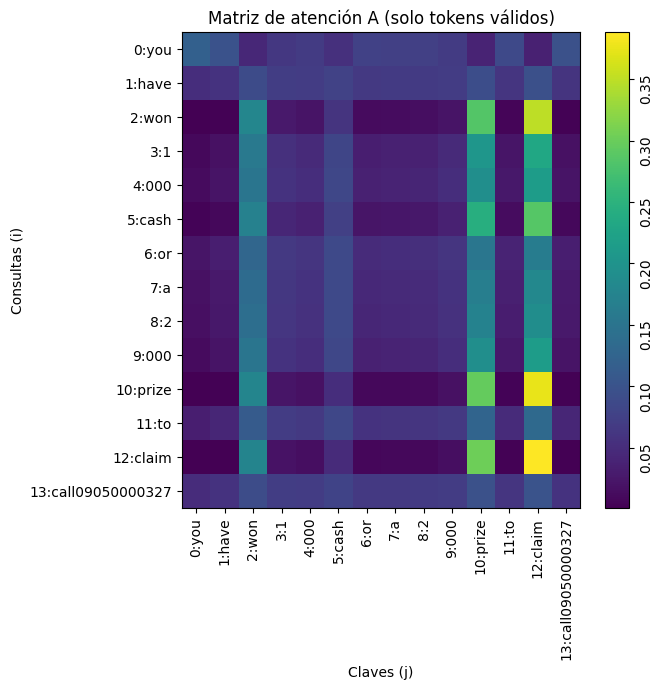

Suma por fila (≈1): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [17]:
# SOLO la matriz de atención (A) con colorbar y ticks a 90°
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import pandas as pd

def show_attention_matrix_only(sample_index, valid_only=True, decimals=3):
    """
    Dibuja SOLO la matriz de atención A (después de softmax).
    - valid_only=True: recorta <pad> y muestra solo tokens válidos.
    """
    # Modelo auxiliar que expone la capa "A"
    A_model = Model(model.input, model.get_layer("A").output)

    # 1) Texto -> ids con padding
    text = X_test.iloc[sample_index]
    seq = tokenizer.texts_to_sequences([text])
    pad = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=max_length)
    ids = pad[0]

    # 2) Matriz A completa (T x T)
    A_full = A_model.predict(pad, verbose=0)[0]

    # 3) Etiquetas
    index_word = tokenizer.index_word
    if valid_only:
        valid_idx = np.where(ids != 0)[0]
        if valid_idx.size == 0:
            print("No hay tokens válidos.")
            return
        tokens = [index_word.get(int(ids[i]), "<unk>") for i in valid_idx]
        labels = [f"{k}:{tok}" for k, tok in enumerate(tokens)]
        A = A_full[np.ix_(valid_idx, valid_idx)]
    else:
        tokens = [index_word.get(int(t), "<unk>") if t!=0 else "<pad>" for t in ids]
        labels = [f"{i}:{tok}" for i, tok in enumerate(tokens)]
        A = A_full

    # 4) Heatmap SOLO de A (con colorbar y ticks a 90°)
    L = len(labels)
    fig_w = max(6, L * 0.5)
    fig_h = max(5, L * 0.5)
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    im = ax.imshow(np.round(A, decimals), aspect='auto')
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelrotation=90)  # ticks del colorbar a 90°

    ax.set_xticks(range(L))
    ax.set_xticklabels(labels, rotation=90, ha='center')  # etiquetas X a 90°
    ax.set_yticks(range(L))
    ax.set_yticklabels(labels)
    ax.set_xlabel("Claves (j)")
    ax.set_ylabel("Consultas (i)")
    ax.set_title("Matriz de atención A (solo tokens válidos)" if valid_only else "Matriz de atención A (incluye <pad>)")
    plt.tight_layout()
    plt.show()

    # 5) (Opcional) imprimir sumas por fila ≈ 1
    row_sums = A.sum(axis=1)
    print("Suma por fila (≈1):", np.round(row_sums, 3))

    # 6) (Opcional) DataFrame con A
    #A_df = pd.DataFrame(np.round(A, decimals), index=labels, columns=labels)
    #display(A_df)

# Ejemplo de uso:
show_attention_matrix_only(sample_index=3, valid_only=True)


[muestra 3] Importancia promedio por clave (columna)


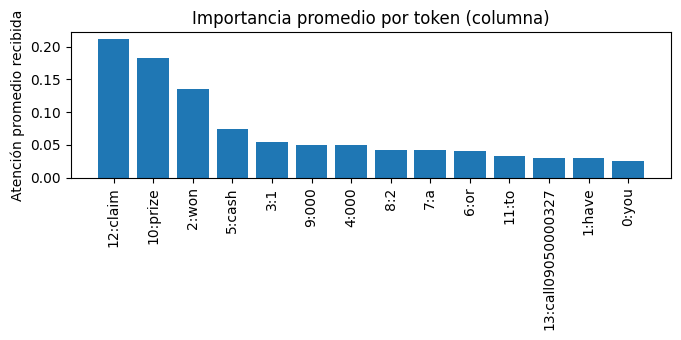

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Model
from IPython.display import display

# Modelo auxiliar para obtener A
A_model = Model(model.input, model.get_layer("A").output)

def _pad_text(text):
    seq = tokenizer.texts_to_sequences([text])
    return tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=max_length)

def _valid_tokens_and_A(pad):
    ids = pad[0]
    valid_idx = np.where(ids != 0)[0]
    index_word = tokenizer.index_word
    tokens = [index_word.get(int(ids[i]), "<unk>") for i in valid_idx]
    A_full = A_model.predict(pad, verbose=0)[0]
    A = A_full[np.ix_(valid_idx, valid_idx)]  # recorta a tokens válidos
    return tokens, A

def bar_scores_for_query(sample_index, query='last', sort=False, decimals=3):
    """
    Barras de los scores (pesos de atención) de una consulta específica:
      - query='last' usa el último token válido
      - query=int usa ese índice de token válido (0..T_valid-1)
    """
    text = X_test.iloc[sample_index]
    pad = _pad_text(text)
    tokens, A = _valid_tokens_and_A(pad)
    T = len(tokens)
    if T == 0:
        print("No hay tokens válidos."); return

    if query == 'last':
        i = T - 1
    elif isinstance(query, int) and 0 <= query < T:
        i = query
    else:
        raise ValueError("query debe ser 'last' o un entero en [0, T_valid-1].")

    w = A[i]  # fila i
    labels = [f"{j}:{tok}" for j, tok in enumerate(tokens)]
    if sort:
        order = np.argsort(-w)
        w = w[order]; labels = [labels[j] for j in order]

    print(f"[muestra {sample_index}] Consulta {i}:{tokens[i]}  | suma fila ≈ {w.sum():.3f}")
    plt.figure(figsize=(max(6, len(labels)*0.5), 3.5))
    plt.bar(range(len(labels)), w)
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.ylabel("Peso de atención (fila i)")
    plt.title(f"Atención de la consulta {i}:{tokens[i]}")
    plt.tight_layout()
    plt.show()

    df = pd.DataFrame({"token": labels, "peso": np.round(w, decimals)})
    display(df)

def bar_scores_per_key_mean(sample_index, sort=False, decimals=3):
    """
    Barras de importancia por clave: promedio de atención que recibe cada token
    (promedio de las filas hacia cada columna).
    """
    text = X_test.iloc[sample_index]
    pad = _pad_text(text)
    tokens, A = _valid_tokens_and_A(pad)
    if len(tokens) == 0:
        print("No hay tokens válidos."); return

    w = A.mean(axis=0)  # promedio por columna
    labels = [f"{j}:{tok}" for j, tok in enumerate(tokens)]
    if sort:
        order = np.argsort(-w)
        w = w[order]; labels = [labels[j] for j in order]

    print(f"[muestra {sample_index}] Importancia promedio por clave (columna)")
    plt.figure(figsize=(max(6, len(labels)*0.5), 3.5))
    plt.bar(range(len(labels)), w)
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.ylabel("Atención promedio recibida")
    plt.title("Importancia promedio por token (columna)")
    plt.tight_layout()
    plt.show()

    #df = pd.DataFrame({"token": labels, "peso_promedio": np.round(w, decimals)})

    #display(df)

# Importancia promedio por token (lo que reciben como claves), ordenada
bar_scores_per_key_mean(sample_index=3, sort=True)


In [19]:
text = X_test.iloc[0]
pad = _pad_text(text)
A_full = A_model.predict(pad, verbose=0)[0]

In [20]:
A_full.shape

(33, 33)


**Tareas.**

1. Elige un mensaje de `X_test` (índice $k$) y obtén $A$ **solo para tokens válidos** (sin `<pad>`), de tamaño $T\times T$.
2. Calcula y reporta:

   * $\textbf{row_sums} = A.\text{sum(axis=}1)$  $\rightarrow$ ¿qué valores te da y por qué?
   * $\textbf{mean_axis1} = A.\text{mean(axis=}1)$ $\rightarrow$ ¿por qué es aproximadamente $1/T$ en todas las filas?
   * $\textbf{mean_axis0} = A.\text{mean(axis=}0)$ $\rightarrow$ interprétalo como **importancia promedio recibida** por token (columna).
   * Verifica que $\sum_j \text{mean_axis0}[j] \approx 1$. Explica por qué **siempre** pasa.




# Positional Encoding: necesidad y formulación matemática

El **mecanismo de self-attention** en Transformers compara todas las palabras de una secuencia entre sí, pero **no sabe nada del orden**.  
- Para el modelo, las frases:
  - `"el perro muerde al hombre"`
  - `"el hombre muerde al perro"`
  
producen exactamente las mismas atenciones si no incorporamos información posicional.

Necesitamos una forma de indicar **en qué posición** aparece cada palabra en la secuencia.




## Estrategia: Positional Encoding
En lugar de añadir un índice entero (0,1,2,...), los Transformers agregan un **vector posicional** a cada embedding de palabra.  
- Cada dimensión del embedding codifica la posición usando funciones **senoidales y cosenoidales** de distintas frecuencias.  
- Esto permite que el modelo aprenda **relaciones relativas** (distancia entre posiciones) y no solo absolutas.




##Fórmula matemática (Vaswani et al., 2017)

Dado un embedding de dimensión \(d_\text{model}\) y una posición \(pos\):

$$
PE(pos, 2i) = \sin\left(\frac{pos}{10000^{2i/d_\text{model}}}\right)
$$

$$
PE(pos, 2i+1) = \cos\left(\frac{pos}{10000^{2i/d_\text{model}}}\right)
$$

- $pos$: índice de la posición en la secuencia (0, 1, 2, …).  
- $i$: índice de la dimensión del embedding.  
- Cada par de dimensiones (2i y 2i+1) usa seno y coseno con distintas frecuencias.



Intuición
- Las dimensiones de bajo índice varían lentamente → capturan posiciones globales.  
- Las dimensiones de alto índice varían rápidamente → capturan posiciones locales.  
- Gracias a senos y cosenos, cada posición se representa con un **patrón único y continuo**.

---

¡Hecho! Actualicé el texto con el desglose pedido y afiné los puntos clave (frecuencias, shapes y cómo aparece en $QK^\top$).

---

# 1) Conexión con Fourier

La PE sinusoidal construye, para cada posición $p$, un vector con **senos y cosenos a múltiples frecuencias**:

$$
\phi(p)=\big[\sin(\omega_0 p),\cos(\omega_0 p),\;\sin(\omega_1 p),\cos(\omega_1 p),\;\dots\big],
\quad
\omega_i=10000^{-\tfrac{2i}{d_{\text{model}}}}.
$$

Este conjunto $\{\sin(\omega_i p),\cos(\omega_i p)\}$ actúa como una **base tipo Fourier** (sobre posiciones discretas). Al **combinar frecuencias** rápidas y lentas puedes representar patrones **locales** (variación rápida) y **globales** (variación lenta) a lo largo de la secuencia.

> Nota de convención: con la definición usual $\omega_i=10000^{-2i/d}$, **índices pequeños** $i$ ⇒ **frecuencia alta** (varía rápido); **índices grandes** $i$ ⇒ **frecuencia baja** (varía lento).


# 2) “Demostración” clave: depende del desplazamiento relativo

La propiedad central es que la **similitud** entre posiciones **depende del desfase** $k=p'-p$.

Para un par seno–coseno a la misma $\omega$:

$$
\sin(\omega p)\sin(\omega p')+\cos(\omega p)\cos(\omega p')
=\cos\big(\omega(p-p')\big)=\cos(\omega k).
$$

Sumando sobre todas las frecuencias $\{\omega_i\}$:

$$
\phi(p)\cdot \phi(p')=\sum_i \cos\big(\omega_i (p-p')\big).
$$

Es decir, la similitud posicional es una **función del desplazamiento** $k$ (kernel **estacionario**). Por el teorema de **Bochner**, combinaciones de cosenos pueden aproximar muchos kernels en $\mathbb{Z}$. En la práctica, al pasar $\phi(p)$ por proyecciones lineales para $Q$ y $K$, los términos posicionales que entran en $Q_i\cdot K_j$ resultan en **polinomios trigonométricos en $i-j$** (distancia relativa).

Forma equivalente (muy intuitiva):

$$
\begin{bmatrix}\sin((p+k)\omega)\\ \cos((p+k)\omega)\end{bmatrix}
=
\underbrace{\begin{bmatrix}\cos(k\omega)&\sin(k\omega)\\ -\sin(k\omega)&\cos(k\omega)\end{bmatrix}}_{\text{rotación}}
\begin{bmatrix}\sin(p\omega)\\ \cos(p\omega)\end{bmatrix}.
$$

Un **desplazamiento** $k$ es una **rotación 2D** por par (seno, coseno); por eso la PE codifica bien **distancias relativas**.



# 3) Intuición práctica: ¿por qué funciona?

* **Rompe la invariancia a permutaciones**: sin PE, el orden no se distingue; con PE, sí.
* **Multiescala**:

  * $i$ pequeño ⇒ $\omega$ grande ⇒ **cambio rápido** (detalle **local**).
  * $i$ grande ⇒ $\omega$ pequeña ⇒ **cambio lento** (tendencia **global**).
* **Fase completa** (seno + coseno): evita ambigüedades y mantiene **amplitud acotada** (estabilidad).
* **Linealidad del desplazamiento** (rotación): facilita que, tras proyecciones aprendidas, la atención **dependa de $i-j$** cuando la tarea lo requiere.
* **Extrapolación**: al ser analítica (no entrenable), puede generalizar a longitudes no vistas.

> La PE **no “prioriza” vecinos por sí sola**; solo aporta la señal. Si quieres un sesgo explícito hacia lo cercano, usa **posiciones relativas** (Shaw/T5), **RoPE** (rotary), **ALiBi** o **ventanas locales**.



## Shapes y cómo aparece en $QK^\top$

* **PE (features)**: $\Phi\in\mathbb{R}^{n\times d}$ (p. ej., $33\times 64$).
* **Embeddings**: $X\in\mathbb{R}^{n\times d}$ (o $(B,n,d)$ con batch).
* **Suma**: $X' = X+\Phi$ ⇒ $(B,n,d)$.

Con $W_Q,W_K\in\mathbb{R}^{d\times d_k}$:

$$
Q=(X+\Phi)W_Q,\quad K=(X+\Phi)W_K,\quad
QK^\top=(X+\Phi)AW^\top(X+\Phi)^\top,\ \ A=W_QW_K^\top.
$$

Se descompone en:

$$
\underbrace{XAX^\top}_{\text{contenido–contenido}}
+\underbrace{XA\Phi^\top+\Phi AX^\top}_{\text{mixtos}}
+\underbrace{\Phi A\Phi^\top}_{\text{posición–posición}} \;\in\mathbb{R}^{n\times n}.
$$

Si $A\approx I$ (intuición), la parte posicional es $\Phi\Phi^\top$ con entradas $\sum_i\cos(\omega_i(p-p'))$: **solo depende de $p-p'$**.



In [21]:
import tensorflow as tf
from tensorflow.keras import layers

class SineCosinePositionalEncoding(layers.Layer):
    def __init__(self, max_len: int, d_model: int, **kwargs):
        super().__init__(trainable=False, **kwargs)
        if d_model % 2 != 0:
            raise ValueError("d_model debe ser par para intercalar sin/cos.")
        self.max_len = max_len
        self.d_model = d_model

        # Construye PE: [1, T, d]
        pos = tf.range(max_len, dtype=tf.float32)[:, tf.newaxis]              # [T, 1]
        i   = tf.range(0, d_model, 2, dtype=tf.float32)[tf.newaxis, :]       # [1, d/2]
        div = tf.exp(-tf.math.log(10000.0) * i / d_model)                    # [1, d/2]
        angles = pos * div                                                   # [T, d/2]
        sin = tf.sin(angles)                                                 # [T, d/2]
        cos = tf.cos(angles)                                                 # [T, d/2]
        pe  = tf.stack([sin, cos], axis=-1)                                  # [T, d/2, 2]
        pe  = tf.reshape(pe, [max_len, d_model])                             # [T, d] (pares=sin, impares=cos)
        self.pe = tf.constant(pe[tf.newaxis, ...], dtype=tf.float32)         # [1, T, d]

    def call(self, x):
        # x: [B, T, d] -> suma por broadcasting (se corta a longitud actual por seguridad)
        T = tf.shape(x)[1]
        return x + self.pe[:, :T, :]
import tensorflow as tf
from tensorflow.keras import layers, Model

tf.keras.backend.clear_session()

# === Dimensiones ===
embed_dim = 128
d_model   = 128
d_k       = 64
d_v       = 64

# Suponemos definidos: max_length, vocab_size
inputs = layers.Input(shape=(max_length,), dtype="int32", name="tokens")

# --- Máscara de padding ---
mask      = layers.Lambda(lambda x: tf.cast(tf.not_equal(x, 0), tf.float32), name="mask_bool")(inputs)      # (B,T)
mask_exp  = layers.Lambda(lambda m: tf.expand_dims(m, axis=1),                       name="mask_exp")(mask)  # (B,1,T)
mask_time = layers.Lambda(lambda m: tf.expand_dims(m, axis=-1),                      name="mask_time")(mask) # (B,T,1)

# --- Embedding -> proyección a d_model ---
emb = layers.Embedding(vocab_size, embed_dim, mask_zero=False, name="E")(inputs)      # (B,T,embed_dim)
x   = layers.Dense(d_model, activation="relu", name="f_mlp")(emb)                     # (B,T,d_model)

# --- Positional Encoding (sinusoidal) y suma ---
x   = SineCosinePositionalEncoding(max_len=max_length, d_model=d_model, name="PE")(x) # (B,T,d_model)

# --- Proyecciones Q, K, V ---
Q = layers.Dense(d_k, use_bias=False, name="W_Q")(x)   # (B,T,d_k)
K = layers.Dense(d_k, use_bias=False, name="W_K")(x)   # (B,T,d_k)
V = layers.Dense(d_v, use_bias=False, name="W_V")(x)   # (B,T,d_v)

# --- Scaled Dot-Product Attention con máscara ---
scale = tf.sqrt(tf.cast(d_k, tf.float32))
scores = layers.Lambda(
    lambda qk: tf.matmul(qk[0], qk[1], transpose_b=True) / scale,
    name="scores"
)([Q, K])  # (B,T,T)

scores_masked = layers.Lambda(
    lambda sm: sm[0] + (1. - sm[1]) * (-1e9),
    name="scores_masked"
)([scores, mask_exp])

A = layers.Softmax(axis=-1, name="A")(scores_masked)          # (B,T,T)
O = layers.Lambda(lambda av: tf.matmul(av[0], av[1]), name="O")([A, V])  # (B,T,d_v)

# --- Pooling temporal enmascarado ---
sum_O     = layers.Lambda(lambda om: tf.reduce_sum(om[0] * om[1], axis=1), name="sum_O")([O, mask_time])   # (B,d_v)
len_valid = layers.Lambda(lambda m: tf.reduce_sum(m, axis=1) + 1e-9, name="len_valid")(mask_time)          # (B,1)
pooled    = layers.Lambda(lambda sl: sl[0] / sl[1], name="pooled")([sum_O, len_valid])                     # (B,d_v)

logits = layers.Dense(1, activation="sigmoid", name="cls")(pooled)

model = Model(inputs, logits, name="MLP_SelfAttn_SMS")
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


Model: "MLP_SelfAttn_SMS"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ tokens (InputLayer) │ (None, 33)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ E (Embedding)       │ (None, 33, 128)   │  1,015,680 │ tokens[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ f_mlp (Dense)       │ (None, 33, 128)   │     16,512 │ E[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PE                  │ (None, 33, 128)   │          0 │ f_mlp[0][0]       │
│ (SineCosinePositio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ W_Q (Dense)         │ (None, 33, 64)    │      8,192 │ PE[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ W_K (Dense)         │ (None, 33, 64)    │      8,192 │ PE[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_bool (Lambda)  │ (None, 33)        │          0 │ tokens[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scores (Lambda)     │ (None, 33, 33)    │          0 │ W_Q[0][0],        │
│                     │                   │            │ W_K[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_exp (Lambda)   │ (None, 1, 33)     │          0 │ mask_bool[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scores_masked       │ (None, 33, 33)    │          0 │ scores[0][0],     │
│ (Lambda)            │                   │            │ mask_exp[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ A (Softmax)         │ (None, 33, 33)    │          0 │ scores_masked[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ W_V (Dense)         │ (None, 33, 64)    │      8,192 │ PE[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ O (Lambda)          │ (None, 33, 64)    │          0 │ A[0][0],          │
│                     │                   │            │ W_V[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_time (Lambda)  │ (None, 33, 1)     │          0 │ mask_bool[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sum_O (Lambda)      │ (None, 64)        │          0 │ O[0][0],          │
│                     │                   │            │ mask_time[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ len_valid (Lambda)  │ (None, 1)         │          0 │ mask_time[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooled (Lambda)     │ (None, 64)        │          0 │ sum_O[0][0],      │
│                     │                   │            │ len_valid[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cls (Dense)         │ (None, 1)         │         65 │ pooled[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,056,833 (4.03 MB)

 Trainable params: 1,056,833 (4.03 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=3, batch_size=128,
    class_weight=class_weights, verbose=1
)

print("\nEval test:")
model.evaluate(X_test_pad, y_test, verbose=1)

# Extraer W_Q, W_K, W_V
W_Q_mat = model.get_layer("W_Q").get_weights()[0]
W_K_mat = model.get_layer("W_K").get_weights()[0]
W_V_mat = model.get_layer("W_V").get_weights()[0]
print("W_Q:", W_Q_mat.shape, "W_K:", W_K_mat.shape, "W_V:", W_V_mat.shape)

# Modelo para ver pesos A (máscara de relevancia)
A_model = tf.keras.Model(model.input, model.get_layer("A").output)

def show_attention(text, top_k=12):
    seq = tokenizer.texts_to_sequences([text])
    pad = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=max_length)
    A_val = A_model.predict(pad, verbose=0)[0]  # (T,T)
    ids = pad[0]
    valid_idx = (ids != 0).nonzero()[0]
    toks = [tokenizer.index_word.get(int(i), "<unk>") for i in ids[valid_idx]]
    A_valid = A_val[valid_idx][:, valid_idx]
    attn_last = A_valid[-1]  # atención del último token a todos
    order = attn_last.argsort()[::-1][:min(top_k, len(attn_last))]
    for j in order:
        print(f"{toks[j]:>15s}  {attn_last[j]:.3f}")


Epoch 1/3
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.7478 - loss: 0.5201 - val_accuracy: 0.7928 - val_loss: 0.3611
Epoch 2/3
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.8834 - loss: 0.2460 - val_accuracy: 0.9605 - val_loss: 0.1166
Epoch 3/3
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9838 - loss: 0.0516 - val_accuracy: 0.9740 - val_loss: 0.0629

Eval test:
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9775 - loss: 0.0605
W_Q: (128, 64) W_K: (128, 64) W_V: (128, 64)


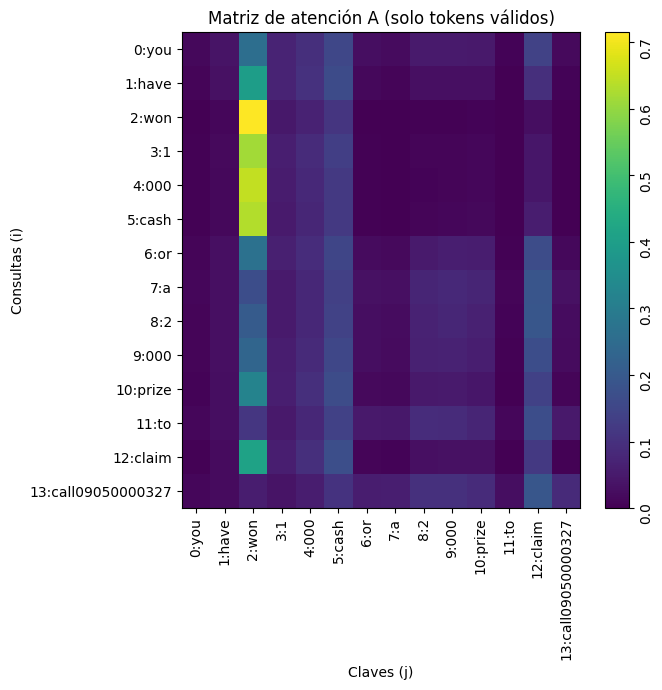

Suma por fila (≈1): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [23]:
# SOLO la matriz de atención (A) con colorbar y ticks a 90°
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import pandas as pd

def show_attention_matrix_only(sample_index, valid_only=True, decimals=3):
    """
    Dibuja SOLO la matriz de atención A (después de softmax).
    - valid_only=True: recorta <pad> y muestra solo tokens válidos.
    """
    # Modelo auxiliar que expone la capa "A"
    A_model = Model(model.input, model.get_layer("A").output)

    # 1) Texto -> ids con padding
    text = X_test.iloc[sample_index]
    seq = tokenizer.texts_to_sequences([text])
    pad = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=max_length)
    ids = pad[0]

    # 2) Matriz A completa (T x T)
    A_full = A_model.predict(pad, verbose=0)[0]

    # 3) Etiquetas
    index_word = tokenizer.index_word
    if valid_only:
        valid_idx = np.where(ids != 0)[0]
        if valid_idx.size == 0:
            print("No hay tokens válidos.")
            return
        tokens = [index_word.get(int(ids[i]), "<unk>") for i in valid_idx]
        labels = [f"{k}:{tok}" for k, tok in enumerate(tokens)]
        A = A_full[np.ix_(valid_idx, valid_idx)]
    else:
        tokens = [index_word.get(int(t), "<unk>") if t!=0 else "<pad>" for t in ids]
        labels = [f"{i}:{tok}" for i, tok in enumerate(tokens)]
        A = A_full

    # 4) Heatmap SOLO de A (con colorbar y ticks a 90°)
    L = len(labels)
    fig_w = max(6, L * 0.5)
    fig_h = max(5, L * 0.5)
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    im = ax.imshow(np.round(A, decimals), aspect='auto')
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelrotation=90)  # ticks del colorbar a 90°

    ax.set_xticks(range(L))
    ax.set_xticklabels(labels, rotation=90, ha='center')  # etiquetas X a 90°
    ax.set_yticks(range(L))
    ax.set_yticklabels(labels)
    ax.set_xlabel("Claves (j)")
    ax.set_ylabel("Consultas (i)")
    ax.set_title("Matriz de atención A (solo tokens válidos)" if valid_only else "Matriz de atención A (incluye <pad>)")
    plt.tight_layout()
    plt.show()

    # 5) (Opcional) imprimir sumas por fila ≈ 1
    row_sums = A.sum(axis=1)
    print("Suma por fila (≈1):", np.round(row_sums, 3))

    # 6) (Opcional) DataFrame con A
    #A_df = pd.DataFrame(np.round(A, decimals), index=labels, columns=labels)
    #display(A_df)

# Ejemplo de uso:
show_attention_matrix_only(sample_index=3, valid_only=True)


[muestra 3] Importancia promedio por clave (columna)


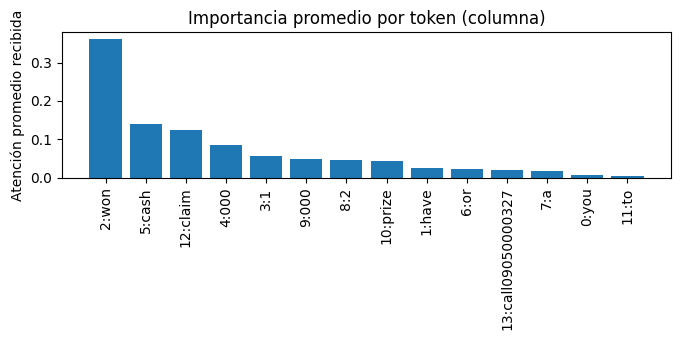

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Model
from IPython.display import display

# Modelo auxiliar para obtener A
A_model = Model(model.input, model.get_layer("A").output)

def _pad_text(text):
    seq = tokenizer.texts_to_sequences([text])
    return tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=max_length)

def _valid_tokens_and_A(pad):
    ids = pad[0]
    valid_idx = np.where(ids != 0)[0]
    index_word = tokenizer.index_word
    tokens = [index_word.get(int(ids[i]), "<unk>") for i in valid_idx]
    A_full = A_model.predict(pad, verbose=0)[0]
    A = A_full[np.ix_(valid_idx, valid_idx)]  # recorta a tokens válidos
    return tokens, A

def bar_scores_for_query(sample_index, query='last', sort=False, decimals=3):
    """
    Barras de los scores (pesos de atención) de una consulta específica:
      - query='last' usa el último token válido
      - query=int usa ese índice de token válido (0..T_valid-1)
    """
    text = X_test.iloc[sample_index]
    pad = _pad_text(text)
    tokens, A = _valid_tokens_and_A(pad)
    T = len(tokens)
    if T == 0:
        print("No hay tokens válidos."); return

    if query == 'last':
        i = T - 1
    elif isinstance(query, int) and 0 <= query < T:
        i = query
    else:
        raise ValueError("query debe ser 'last' o un entero en [0, T_valid-1].")

    w = A[i]  # fila i
    labels = [f"{j}:{tok}" for j, tok in enumerate(tokens)]
    if sort:
        order = np.argsort(-w)
        w = w[order]; labels = [labels[j] for j in order]

    print(f"[muestra {sample_index}] Consulta {i}:{tokens[i]}  | suma fila ≈ {w.sum():.3f}")
    plt.figure(figsize=(max(6, len(labels)*0.5), 3.5))
    plt.bar(range(len(labels)), w)
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.ylabel("Peso de atención (fila i)")
    plt.title(f"Atención de la consulta {i}:{tokens[i]}")
    plt.tight_layout()
    plt.show()

    df = pd.DataFrame({"token": labels, "peso": np.round(w, decimals)})
    display(df)

def bar_scores_per_key_mean(sample_index, sort=False, decimals=3):
    """
    Barras de importancia por clave: promedio de atención que recibe cada token
    (promedio de las filas hacia cada columna).
    """
    text = X_test.iloc[sample_index]
    pad = _pad_text(text)
    tokens, A = _valid_tokens_and_A(pad)
    if len(tokens) == 0:
        print("No hay tokens válidos."); return

    w = A.mean(axis=0)  # promedio por columna
    labels = [f"{j}:{tok}" for j, tok in enumerate(tokens)]
    if sort:
        order = np.argsort(-w)
        w = w[order]; labels = [labels[j] for j in order]

    print(f"[muestra {sample_index}] Importancia promedio por clave (columna)")
    plt.figure(figsize=(max(6, len(labels)*0.5), 3.5))
    plt.bar(range(len(labels)), w)
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.ylabel("Atención promedio recibida")
    plt.title("Importancia promedio por token (columna)")
    plt.tight_layout()
    plt.show()

    #df = pd.DataFrame({"token": labels, "peso_promedio": np.round(w, decimals)})

    #display(df)

# Importancia promedio por token (lo que reciben como claves), ordenada
bar_scores_per_key_mean(sample_index=3, sort=True)


# Tarea
## Prerrequisitos (rápidos)

---

## Parte A — Baseline con sinusoidal fija (control)

1. **Ejecuta** el modelo base (senos/cosenos fijos) tal como está.
2. **Dataset**: usa el mismo conjunto del curso.
3. **Protocolo**:

   * Entrena N épocas (p. ej., 10–20) con `adam`, `batch_size` fijo.
   * Guarda: *train/val loss*, *val accuracy*, **tiempo/época**.

5. **Registra**:

   * Métricas en una **tabla** (ver plantilla abajo).
   * **#Parámetros** del modelo.

> **Entrega A**: tabla con métricas del baseline y breve comentario (3–5 líneas).

---

## Parte B — Sustituir por **Posición Aprendida (absoluta)**

**Tarea técnica**: reemplaza la suma sinusoidal por una **tabla aprendida** de posiciones.

### Pista de implementación (fragmento)

```python
class LearnedPositionalEncoding(layers.Layer):
    def __init__(self, max_len: int, d_model: int, **kwargs):
        super().__init__(**kwargs)
        self.pos_emb = layers.Embedding(input_dim=max_len, output_dim=d_model)

    def call(self, x):
        # x: [B, T, d]
        T = tf.shape(x)[1]
        pos = tf.range(T)[tf.newaxis, :]         # [1, T]
        return x + self.pos_emb(pos)             # [B, T, d]
```

* **Dónde**: sustituye la capa `SineCosinePositionalEncoding` por `LearnedPositionalEncoding` **sin cambiar nada más**.
* **Repite** el *mismo protocolo* de la Parte A (mismas épocas, seed, optimizador, etc.).

> **Entrega B**:
>
> * Código **funcionando** con posición aprendida.
> * Tabla de métricas (entrenamiento/validación y extrapolación).


---

## Parte C — Investigación guiada (Relativa / RoPE / ALiBi)

**No es obligatorio implementarlas** (extra si alguien quiere), pero **sí investigarlas** y **concluir**:

1. **Relativa** (Shaw/T5): sesgos o embeddings por **distancia** $i-j$ inyectados en $QK^\top$.
2. **RoPE** (Rotary): aplica **rotaciones** dependientes de la posición a $Q,K$ por pares de dimensiones → el puntaje depende naturalmente de $i-j$.
3. **ALiBi**: añade un **término lineal** que **penaliza** atenciones lejanas; muy estable con contextos largos.

**Guía para las conclusiones (máx. 1–2 páginas):**

* **Pros/Contras** frente a senos/cosenos fijos:

  * **Parámetros extra** (¿tiene?, ¿cuántos?).
  * **Estabilidad/velocidad de entrenamiento**.
  * **Extrapolación** a longitudes mayores.
  * **Sesgo hacia lo cercano** (¿lo introduce explícitamente o no?).
  * **Simplicidad de implementación**.
* **Cuándo elegirías** cada una (escenarios concretos).

> **Entrega C**: resumen comparativo **claro y conciso**.




In [30]:
import tabulate

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=10, batch_size=128,
    class_weight=class_weights, verbose=1
)

eval_results = model.evaluate(X_test_pad, y_test, verbose=1, return_dict=True)

# Extraer W_Q, W_K, W_V
W_Q_mat = model.get_layer("W_Q").get_weights()[0]
W_K_mat = model.get_layer("W_K").get_weights()[0]
W_V_mat = model.get_layer("W_V").get_weights()[0]
print("W_Q:", W_Q_mat.shape, "W_K:", W_K_mat.shape, "W_V:", W_V_mat.shape)

# Modelo para ver pesos A (máscara de relevancia)
A_model = tf.keras.Model(model.input, model.get_layer("A").output)

def show_attention(text, top_k=12):
    seq = tokenizer.texts_to_sequences([text])
    pad = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=max_length)
    A_val = A_model.predict(pad, verbose=0)[0]  # (T,T)
    ids = pad[0]
    valid_idx = (ids != 0).nonzero()[0]
    toks = [tokenizer.index_word.get(int(i), "<unk>") for i in ids[valid_idx]]
    A_valid = A_val[valid_idx][:, valid_idx]
    attn_last = A_valid[-1]  # atención del último token a todos
    order = attn_last.argsort()[::-1][:min(top_k, len(attn_last))]
    for j in order:
        print(f"{toks[j]:>15s}  {attn_last[j]:.3f}")


# Extraer métricas
metrics_table = []
for metric_name, metric_value in eval_results.items():
    metrics_table.append([metric_name, f"{metric_value:.4f}"])

# Extraer parámetros del modelo
W_Q_mat = model.get_layer("W_Q").get_weights()[0]
W_K_mat = model.get_layer("W_K").get_weights()[0]
W_V_mat = model.get_layer("W_V").get_weights()[0]

# Contar parámetros entrenables
total_params = model.count_params()

# Crear tabla de parámetros
params_table = [
    ["W_Q", str(W_Q_mat.shape), f"{np.prod(W_Q_mat.shape)}"],
    ["W_K", str(W_K_mat.shape), f"{np.prod(W_K_mat.shape)}"],
    ["W_V", str(W_V_mat.shape), f"{np.prod(W_V_mat.shape)}"],
    ["Total trainable parameters", "", f"{total_params}"]
]

# Imprimir tablas
print("\n=== Model Metrics ===")
print(tabulate.tabulate(metrics_table, headers=["Metric", "Value"], tablefmt="grid"))

print("\n=== Model Parameters ===")
print(tabulate.tabulate(params_table, headers=["Parameter", "Shape", "Count"], tablefmt="grid"))


Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9998 - loss: 1.1504e-04 - val_accuracy: 0.9883 - val_loss: 0.0600
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - accuracy: 0.9995 - loss: 2.2111e-04 - val_accuracy: 0.9883 - val_loss: 0.0607
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 1.0000 - loss: 4.6995e-05 - val_accuracy: 0.9883 - val_loss: 0.0614
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.9998 - loss: 1.0526e-04 - val_accuracy: 0.9883 - val_loss: 0.0620
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9999 - loss: 6.0974e-05 - val_accuracy: 0.9883 - val_loss: 0.0626
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9999 - loss: 5.2254e-05 - val_accuracy: 0.9883 - val_loss: 0.0633
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.9996 - loss: 1.9291e-04 - val_accuracy: 0.9883 - val_loss: 0.0639
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.9999 - loss: 4.8

In [32]:
class LearnedPositionalEncoding(layers.Layer):
    def __init__(self, max_len: int, d_model: int, **kwargs):
        super().__init__(**kwargs)
        self.pos_emb = layers.Embedding(input_dim=max_len, output_dim=d_model)

    def call(self, x):
        # x: [B, T, d]
        T = tf.shape(x)[1]
        pos = tf.range(T)[tf.newaxis, :]         # [1, T]
        return x + self.pos_emb(pos)             # [B, T, d]

import tensorflow as tf
from tensorflow.keras import layers, Model

tf.keras.backend.clear_session()

# === Dimensiones ===
embed_dim = 128
d_model   = 128
d_k       = 64
d_v       = 64

# Suponemos definidos: max_length, vocab_size
inputs = layers.Input(shape=(max_length,), dtype="int32", name="tokens")

# --- Máscara de padding ---
mask      = layers.Lambda(lambda x: tf.cast(tf.not_equal(x, 0), tf.float32), name="mask_bool")(inputs)      # (B,T)
mask_exp  = layers.Lambda(lambda m: tf.expand_dims(m, axis=1),                       name="mask_exp")(mask)  # (B,1,T)
mask_time = layers.Lambda(lambda m: tf.expand_dims(m, axis=-1),                      name="mask_time")(mask) # (B,T,1)

# --- Embedding -> proyección a d_model ---
emb = layers.Embedding(vocab_size, embed_dim, mask_zero=False, name="E")(inputs)      # (B,T,embed_dim)
x   = layers.Dense(d_model, activation="relu", name="f_mlp")(emb)                     # (B,T,d_model)

# --- Positional Encoding (sinusoidal) y suma ---
x   = LearnedPositionalEncoding(max_len=max_length, d_model=d_model, name="PE")(x) # (B,T,d_model)

# --- Proyecciones Q, K, V ---
Q = layers.Dense(d_k, use_bias=False, name="W_Q")(x)   # (B,T,d_k)
K = layers.Dense(d_k, use_bias=False, name="W_K")(x)   # (B,T,d_k)
V = layers.Dense(d_v, use_bias=False, name="W_V")(x)   # (B,T,d_v)

# --- Scaled Dot-Product Attention con máscara ---
scale = tf.sqrt(tf.cast(d_k, tf.float32))
scores = layers.Lambda(
    lambda qk: tf.matmul(qk[0], qk[1], transpose_b=True) / scale,
    name="scores"
)([Q, K])  # (B,T,T)

scores_masked = layers.Lambda(
    lambda sm: sm[0] + (1. - sm[1]) * (-1e9),
    name="scores_masked"
)([scores, mask_exp])

A = layers.Softmax(axis=-1, name="A")(scores_masked)          # (B,T,T)
O = layers.Lambda(lambda av: tf.matmul(av[0], av[1]), name="O")([A, V])  # (B,T,d_v)

# --- Pooling temporal enmascarado ---
sum_O     = layers.Lambda(lambda om: tf.reduce_sum(om[0] * om[1], axis=1), name="sum_O")([O, mask_time])   # (B,d_v)
len_valid = layers.Lambda(lambda m: tf.reduce_sum(m, axis=1) + 1e-9, name="len_valid")(mask_time)          # (B,1)
pooled    = layers.Lambda(lambda sl: sl[0] / sl[1], name="pooled")([sum_O, len_valid])                     # (B,d_v)

logits = layers.Dense(1, activation="sigmoid", name="cls")(pooled)

model = Model(inputs, logits, name="MLP_SelfAttn_SMS")
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


Model: "MLP_SelfAttn_SMS"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ tokens (InputLayer) │ (None, 33)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ E (Embedding)       │ (None, 33, 128)   │  1,015,680 │ tokens[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ f_mlp (Dense)       │ (None, 33, 128)   │     16,512 │ E[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PE                  │ (None, 33, 128)   │      4,224 │ f_mlp[0][0]       │
│ (LearnedPositional… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ W_Q (Dense)         │ (None, 33, 64)    │      8,192 │ PE[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ W_K (Dense)         │ (None, 33, 64)    │      8,192 │ PE[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_bool (Lambda)  │ (None, 33)        │          0 │ tokens[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scores (Lambda)     │ (None, 33, 33)    │          0 │ W_Q[0][0],        │
│                     │                   │            │ W_K[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_exp (Lambda)   │ (None, 1, 33)     │          0 │ mask_bool[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scores_masked       │ (None, 33, 33)    │          0 │ scores[0][0],     │
│ (Lambda)            │                   │            │ mask_exp[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ A (Softmax)         │ (None, 33, 33)    │          0 │ scores_masked[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ W_V (Dense)         │ (None, 33, 64)    │      8,192 │ PE[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ O (Lambda)          │ (None, 33, 64)    │          0 │ A[0][0],          │
│                     │                   │            │ W_V[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_time (Lambda)  │ (None, 33, 1)     │          0 │ mask_bool[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sum_O (Lambda)      │ (None, 64)        │          0 │ O[0][0],          │
│                     │                   │            │ mask_time[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ len_valid (Lambda)  │ (None, 1)         │          0 │ mask_time[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooled (Lambda)     │ (None, 64)        │          0 │ sum_O[0][0],      │
│                     │                   │            │ len_valid[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cls (Dense)         │ (None, 1)         │         65 │ pooled[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,061,057 (4.05 MB)

 Trainable params: 1,061,057 (4.05 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=10, batch_size=128,
    class_weight=class_weights, verbose=1
)

eval_results = model.evaluate(X_test_pad, y_test, verbose=1, return_dict=True)

# Extraer W_Q, W_K, W_V
W_Q_mat = model.get_layer("W_Q").get_weights()[0]
W_K_mat = model.get_layer("W_K").get_weights()[0]
W_V_mat = model.get_layer("W_V").get_weights()[0]
print("W_Q:", W_Q_mat.shape, "W_K:", W_K_mat.shape, "W_V:", W_V_mat.shape)

# Modelo para ver pesos A (máscara de relevancia)
A_model = tf.keras.Model(model.input, model.get_layer("A").output)

def show_attention(text, top_k=12):
    seq = tokenizer.texts_to_sequences([text])
    pad = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=max_length)
    A_val = A_model.predict(pad, verbose=0)[0]  # (T,T)
    ids = pad[0]
    valid_idx = (ids != 0).nonzero()[0]
    toks = [tokenizer.index_word.get(int(i), "<unk>") for i in ids[valid_idx]]
    A_valid = A_val[valid_idx][:, valid_idx]
    attn_last = A_valid[-1]  # atención del último token a todos
    order = attn_last.argsort()[::-1][:min(top_k, len(attn_last))]
    for j in order:
        print(f"{toks[j]:>15s}  {attn_last[j]:.3f}")


# Extraer métricas
metrics_table = []
for metric_name, metric_value in eval_results.items():
    metrics_table.append([metric_name, f"{metric_value:.4f}"])

# Extraer parámetros del modelo
W_Q_mat = model.get_layer("W_Q").get_weights()[0]
W_K_mat = model.get_layer("W_K").get_weights()[0]
W_V_mat = model.get_layer("W_V").get_weights()[0]

# Contar parámetros entrenables
total_params = model.count_params()

# Crear tabla de parámetros
params_table = [
    ["W_Q", str(W_Q_mat.shape), f"{np.prod(W_Q_mat.shape)}"],
    ["W_K", str(W_K_mat.shape), f"{np.prod(W_K_mat.shape)}"],
    ["W_V", str(W_V_mat.shape), f"{np.prod(W_V_mat.shape)}"],
    ["Total trainable parameters", "", f"{total_params}"]
]

# Imprimir tablas
print("\n=== Model Metrics ===")
print(tabulate.tabulate(metrics_table, headers=["Metric", "Value"], tablefmt="grid"))

print("\n=== Model Parameters ===")
print(tabulate.tabulate(params_table, headers=["Parameter", "Shape", "Count"], tablefmt="grid"))

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.8628 - loss: 0.5938 - val_accuracy: 0.9650 - val_loss: 0.1142
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9802 - loss: 0.0781 - val_accuracy: 0.9857 - val_loss: 0.0476
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9949 - loss: 0.0280 - val_accuracy: 0.9874 - val_loss: 0.0388
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.9974 - loss: 0.0086 - val_accuracy: 0.9883 - val_loss: 0.0327
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.9982 - loss: 0.0053 - val_accuracy: 0.9892 - val_loss: 0.0343
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9998 - loss: 0.0016 - val_accuracy: 0.9910 - val_loss: 0.0364
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.9990 - loss: 0.0024 - val_accuracy: 0.9901 - val_loss: 0.0377
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.9998 - loss: 5.1282e-04 - val_accuracy: 0.9892